In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import re

import keras
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
train_file = "train.csv"
test_file = "test.csv"

train_df = pd.read_csv(train_file, index_col = 0, dtype={"Age": np.float64})
test_df = pd.read_csv(test_file, index_col = 0, dtype={"Age": np.float64})

train_df['train'] = True
test_df['train'] = False
test_df['Survived'] = None
df = pd.concat([train_df, test_df], sort=False)
del train_df
del test_df

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
Survived    891 non-null object
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
train       1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 124.0+ KB


In [4]:
#drop useless ticket column
df = df.drop(columns = 'Ticket')

# drop non_embarked people and the missing fare
#df = df.dropna(how='all', subset = ['Embarked'])
#df = df.dropna(how='all', subset = ['Fare'])
df['Embarked'] = df['Embarked'].fillna('S')



#fill age and create cat
#df['Age'] = df['Age'].fillna(value = df['Age'].median())
age_avg = df['Age'].mean()
age_std = df['Age'].std()
age_null_count = df['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
df['Age'][np.isnan(df['Age'])] = age_null_random_list
df['Age'] = df['Age'].astype(int)

#nb of training exemples
m = df.shape[0]

#find the Surname to det families
df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0].lower())
#find the name length
df["Name_len"] = df["Name"].apply(lambda x: len(x))

#add total nb of relatives on the boat
df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['Family_size'] = pd.cut(df['Family_size'], bins=[0,1,4,20], labels=[0,1,2])



#find the title
df['Title'] = df['Name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
                 "Master": 4, "Dr": 5, "Rev": 6,
                 "Major": 7, "Col": 7, "Mlle": 2,
                 "Mme": 3,"Don": 9,"Dona": 9,
                 "Lady": 10, "Countess": 10,
                 "Jonkheer": 10, "Sir": 9,
                 "Capt": 7, "Ms": 2}
df["Title"] = df.loc[:,'Title'].map(title_mapping)


#create an index for the cabin, after sorting since similar numbers should be close
tmp_df = df
df = df.sort_values(by = 'Cabin')
le1 = preprocessing.LabelEncoder()
le1.fit(df['Cabin'].values.astype(str))
df['Cabin'] = le1.transform(df['Cabin'].values.astype(str))
df = df.reset_index()
df = df.set_index('PassengerId')

#create an index for each family by comparing Surname and numbers giving relatives
le2 = preprocessing.LabelEncoder()
arrays = [df['SibSp'].values, df['Parch'].values, df['Surname'].values]
joint_criterias = [str(arrays[0][i]) + str(arrays[1][i]) + str(arrays[2][i]) for i in range(m)]
le2.fit(joint_criterias)
df['Family_ind'] = le2.transform(joint_criterias)

#index for the departing port, the sex and the surname while we use it
cols = ['Embarked', 'Sex', 'Surname']
encoders = []
for col in cols:    
    le = preprocessing.LabelEncoder()
    le.fit(df[col].values.astype(str))
    df[col] = le.transform(df[col].values.astype(str))
    encoders.append(le)

#add mean, min and max age of the family
df['Mean_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.mean())
df['Min_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.min())
df['Max_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.max())

#name as well as family are no longer useful, since information is now contained elsewhere ??? essayons avec d'abord puis sans
df = df.drop(columns = ['Name', 'SibSp', 'Parch'])

#replace Fare abd create categories
df['Fare'] = df['Fare'].fillna(df['Fare'].loc[(df['Pclass'] == 3) & (df['Embarked'] == 2) & (df['Cabin'] == 186)].median())



#normalize the rest of the Data ?

/sgoinfre/goinfre/Perso/trmonich/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
print(df.tail(5))

            Survived  Pclass  Sex  Age     Fare  Cabin  Embarked  train  \
PassengerId                                                               
1304            None       3    0   28   7.7750    186         2  False   
1305            None       3    1   16   8.0500    186         2  False   
1307            None       3    1   38   7.2500    186         2  False   
1308            None       3    1   32   8.0500    186         2  False   
1309            None       3    1   39  22.3583    186         0  False   

             Surname  Name_len Family_size  Title  Family_ind  Mean_age  \
PassengerId                                                               
1304             338        30           0      2         265      28.0   
1305             758        18           0      1         608      16.0   
1307             704        28           0      1         563      38.0   
1308             834        19           0      1         669      31.5   
1309             639    

In [30]:
train_df = df.loc[lambda df:df['train'] == True].drop(columns = 'train')
test_df = df.loc[lambda df:df['train'] == False].drop(columns = 'train')

y = train_df['Survived'].astype(bool).values
X = train_df.drop(columns = 'Survived').values

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_df.drop(columns = 'Survived').values

/sgoinfre/goinfre/Perso/trmonich/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/sgoinfre/goinfre/Perso/trmonich/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/sgoinfre/goinfre/Perso/trmonich/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/sgoinfre/goinfre/Perso/trmonich/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'sc

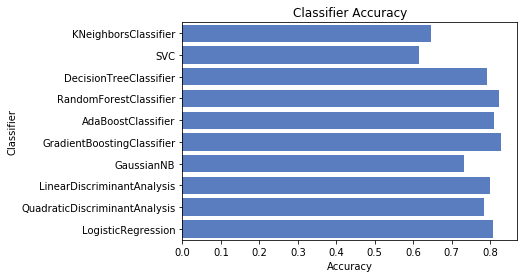

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

#X = train[0::, 1::]
#y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [33]:
models = []
kf = KFold(10, random_state=42)
for train_ind, test_ind in kf.split(X):
    X_tr, X_test = X[train_ind], X[test_ind]
    y_tr, y_test = y[train_ind], y[test_ind]
    model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=1200, verbose=0, max_depth=2)
    model.fit(X_tr, y_tr)
    print(model.score(X_tr, y_tr))
    print(model.score(X_val, y_val))
    models.append(model)

1.0
0.9664804469273743
1.0
0.9888268156424581
1.0
0.9832402234636871
1.0
0.9776536312849162
1.0
0.9776536312849162
1.0
0.9776536312849162
1.0
0.9888268156424581
1.0
0.994413407821229
1.0
0.9776536312849162
1.0
0.9720670391061452


In [31]:
#Make the predictions and average by best 2 out of 3 ?
predictions = []
for model in models:
    prediction = model.predict(X_test)
    predictions.append(prediction.astype(int))
    
average = sum(predictions)
average = average / 10
average = (average >= 0.5).astype(int)
print(average.shape)

(418,)


In [32]:
PassengerId =np.array(test_df.index).astype(int)
my_prediction = pd.DataFrame(average, PassengerId, columns = ["Survived"])
print(my_prediction)

my_prediction.to_csv("GDBpred.csv", index_label = ["PassengerId"])

      Survived
1100         1
1223         0
920          0
1004         1
1185         1
1266         1
938          1
1058         0
1107         1
1282         0
1197         1
918          1
1289         1
1179         0
904          1
1235         1
1264         0
916          1
956          1
1034         0
1076         1
951          1
1200         0
984          1
1208         0
969          1
1248         1
1306         1
1227         1
1069         0
...        ...
1269         0
1271         1
1272         0
1273         0
1274         1
1275         1
1276         0
1277         1
1278         0
1279         0
1280         0
1281         0
1284         1
1285         0
1286         0
1288         1
1290         0
1291         0
1293         0
1294         1
1295         0
1298         0
1300         1
1301         1
1302         1
1304         0
1305         0
1307         0
1308         0
1309         1

[418 rows x 1 columns]


In [ ]:
features = train_df.drop(columns = 'Survived').columns.values
importances = model1.feature_importances_
indices = np.argsort(importances)

for name, importance in zip(features, importances):
    print(name, "=", importance)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
def create_model(optimizer='Adam'):

    input_dim = X_tr.shape[1]

    l2 = regularizers.l2(0.01)

    model2 = Sequential()
    model2.add(Dense(32, activation = 'relu', kernel_initializer='glorot_normal', input_dim=input_dim, kernel_regularizer=l2))
    model2.add(Dense(64, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(128, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(164, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(16, activation = 'relu', kernel_initializer='glorot_normal'))
    model2.add(Dense(1, activation = 'sigmoid', kernel_initializer='glorot_normal'))

    model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model2

optimizer = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
histories = []
models = []
kf = KFold(10, random_state=42)
for train_ind, test_ind in kf.split(X):
    X_tr, X_test = X[train_ind], X[test_ind]
    y_tr, y_test = y[train_ind], y[test_ind]
    model = create_model()
    history = model.fit(X_tr, y_tr, batch_size=64, epochs=2500, validation_data=(X_val,y_val))
    models.append(model)
    histories.append(history)

In [ ]:
for i, history in enumerate(histories):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy model ' + str(i))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
from keras.models import load_model
scores= []
for i, model in enumerate(models):
    score = model.evaluate(X, y, batch_size = 64)
    print(model.metrics_names)
    print(score)
    scores.append(score)
    model.save('my_model' + str(i) + '.h5')

In [ ]:
#choose the best models
best_models = []
for i, model in enumerate(models):
    if scores[i][1] >= 0.90:
        best_models.append(model)
print(best_models)

In [ ]:
#print()
#test_df['Fare'] = test_df['Fare'].fillna(8.05)
#test_df.info()
#X_test = test_df.drop(columns = 'Survived').values
#print(X_test)

In [ ]:
#Make the predictions and average by best 2 out of 3 ?
predictions = []
for model in best_models:
    prediction = model.predict(X_test, batch_size = 64)
    prediction = (prediction >= 0.5)
    predictions.append(prediction)
    print(prediction)

In [ ]:
average = predictions[0] * 1 + predictions[1] * 1 + predictions[2] * 1
average = average / 3
average = (average >= 0.5).astype(int)
print(average)

In [ ]:
PassengerId =np.array(test_df.index).astype(int)
my_prediction = pd.DataFrame(average, PassengerId, columns = ["Survived"])
print(my_prediction)

my_prediction.to_csv("my_prediction.csv", index_label = ["PassengerId"])